# 09. PyTorch Model deployment

Machine learning model deployment is the act of making your maching learning models available to someone or something else


## 0. Setup


In [ ]:
import torch
import torchvision

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo.. installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# importing the going_modular directory
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo.. installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 39.57 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

The dataset we're going to use for deploying a FoodVision mini model is..

Pizza,steak,sushi 20% dataset (pizza, steak and sushi classes from Food101 dataset, random 20% of sample)

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

**FoodVision Mini ideal use case:** A model that perfroms well and fast
1. Performs well: 95%+ accuracy
2. Fast: as close to real-time as possible (30FPS+ or 30ms latency)


To try and achive this goals, we're going to build two model experiments:
1. EffNetB2 feature extractor
2. ViT feature extractor


## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term fo a transfer learning model that has it's base layers frozen and output layers (or head layers) customized to a certain problem.



In [ ]:
#1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # Default -> best available

# 2. Get EffNetB2 transforms
effnet_b2_transforms = effnetb2_weights.transforms()

# 3. Setup model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Freeze the base layers in the model
for params in effnetb2.parameters():
  params.requires_grad = False


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 101MB/s]


In [ ]:
from torchinfo import summary
# summary(effnetb2,
#         input_size=(1,3,224,224),
#         col_names=["input_size","output_size","num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features=1408,out_features=3,bias=True))

In [ ]:
# summary(effnetb2,
#         input_size=(1,3,224,224),
#         col_names=["input_size","output_size","num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## 3.1 Creating a functin to make an EffNetB2 feature extractor


In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed: int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,out_features=num_classes))

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                        seed=42)


In [ ]:
# summary(effnetb2,
#         input_size=(1,3,288,288),
#         col_names=["input_size","output_size","num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
### 3.2 Creating DataLoaders for EffNetB2

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2 , class_names= data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
len(train_dataloader_effnetb2),len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)

# Training function (in engine.py)
set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9683 | train_acc: 0.5479 | test_loss: 0.7345 | test_acc: 0.8886
Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8542 | test_loss: 0.5936 | test_acc: 0.9136
Epoch: 3 | train_loss: 0.5783 | train_acc: 0.9062 | test_loss: 0.4949 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4518 | train_acc: 0.8958 | test_loss: 0.4404 | test_acc: 0.9131
Epoch: 5 | train_loss: 0.4220 | train_acc: 0.9146 | test_loss: 0.4011 | test_acc: 0.9199
Epoch: 6 | train_loss: 0.4274 | train_acc: 0.8958 | test_loss: 0.3558 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4294 | train_acc: 0.8292 | test_loss: 0.3339 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3906 | train_acc: 0.8938 | test_loss: 0.3496 | test_acc: 0.9170
Epoch: 9 | train_loss: 0.3866 | train_acc: 0.8938 | test_loss: 0.3201 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.3694 | train_acc: 0.8646 | test_loss: 0.2878 | test_acc: 0.9563


### 3.4 Inspectiong loss curvs


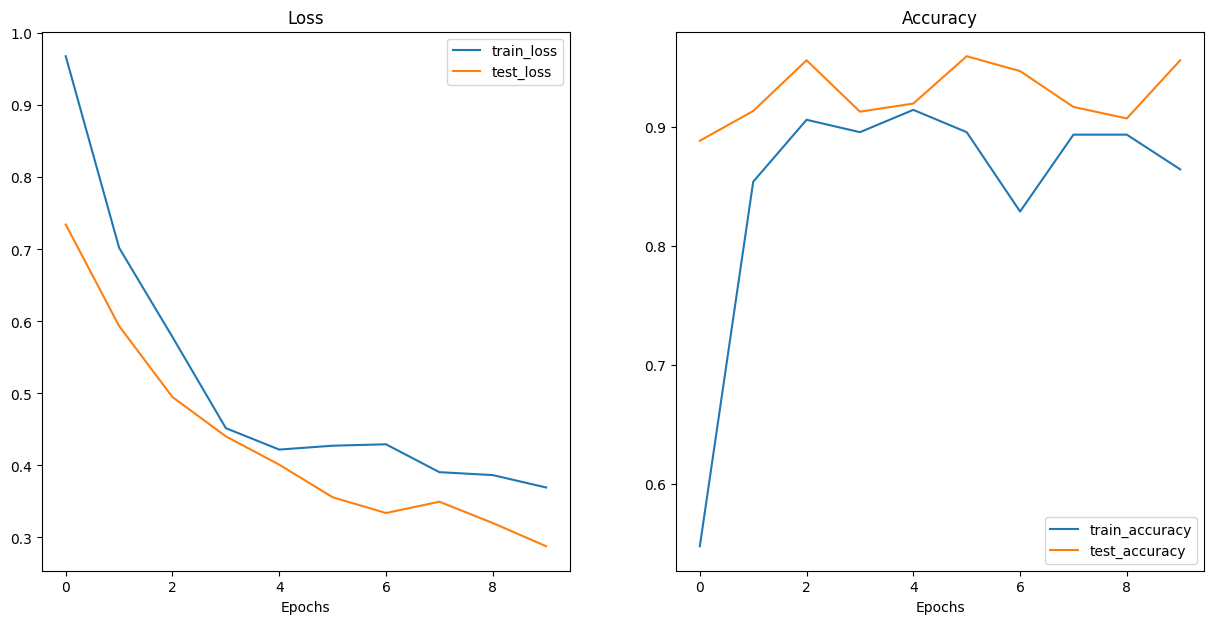

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir = "models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extactor model

Why is it important to consider the size?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resouces.

So if our model file is too large, we may not be able to store/run it

In [ ]:
from pathlib import Path

# Get the model size (convert it to mb later)
pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Model size: {round(pretrained_effnetb2_model_size,2)} MB ")

Model size: 29.86 MB 


### 3.7 Collecting stats

In [ ]:
# Count number of params in effnetb2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "num_params": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2878044843673706,
 'test_acc': 0.95625,
 'num_params': 7705221,
 'model_size (MB)': 29.8633975982666}

## 4. Creating ViT feature extractor

In [ ]:
# Check out the ViT head layers
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all base layers
  for param in model.parameters():
    param.requires_grad=False

  # Change the classifier head
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# from torchinfo import summary
# summary(vit,
#         input_size=(1,3,224,224),
#         col_names=["input_size","output_size","num_params","trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for vit feature exractor

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_name = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                      test_dir=test_dir,
                                                                                      transform=vit_transforms,
                                                                                      batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_name

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training
vit_results = engine.train(model=vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5278 | train_acc: 0.8625 | test_loss: 0.2046 | test_acc: 0.9812
Epoch: 2 | train_loss: 0.1896 | train_acc: 0.9542 | test_loss: 0.1133 | test_acc: 0.9812
Epoch: 3 | train_loss: 0.1357 | train_acc: 0.9583 | test_loss: 0.0876 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1246 | train_acc: 0.9708 | test_loss: 0.0767 | test_acc: 0.9812
Epoch: 5 | train_loss: 0.0955 | train_acc: 0.9771 | test_loss: 0.0746 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.1137 | train_acc: 0.9792 | test_loss: 0.0696 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0692 | train_acc: 0.9854 | test_loss: 0.0660 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0603 | train_acc: 0.9896 | test_loss: 0.0656 | test_acc: 0.9812
Epoch: 9 | train_loss: 0.0529 | train_acc: 0.9938 | test_loss: 0.0639 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.0471 | train_acc: 0.9958 | test_loss: 0.0607 | test_acc: 0.9812


### 4.3 Plot loss curves

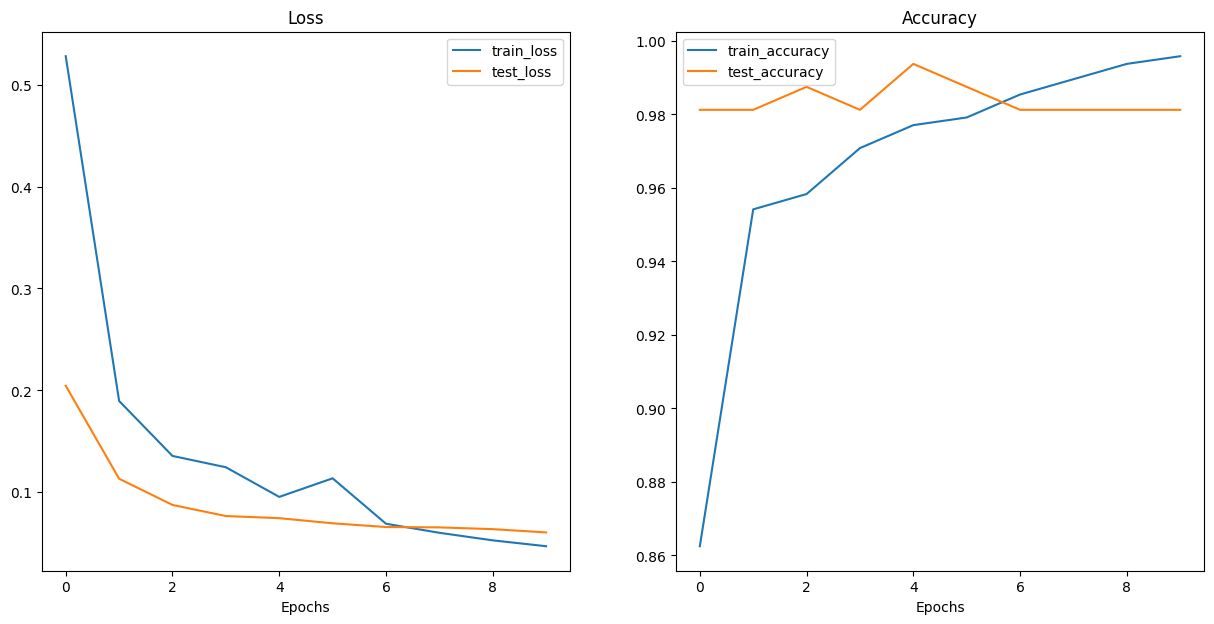

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
### 4.4 Saving ViT feature extractor
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir = "models",
                 model_name = "09_pretrained_vit_feature_extractor_pizz_steak_sushi_20_percent.pth")


[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizz_steak_sushi_20_percent.pth


### 4.5 Checking size of model

In [ ]:
from pathlib import Path

# Get the model size (convert it to mb later)
pretrained_vit_model_size = Path("/content/models/09_pretrained_vit_feature_extractor_pizz_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Model size: {round(pretrained_vit_model_size,2)} MB ")

Model size: 327.37 MB 


### 4.6 Collecting vit feature extractor stats

In [ ]:
# Count number of parameters
vit_total_params = sum(torch.numel(params) for params in vit.parameters()) # numel -> number of elements
vit_total_params

85800963

In [ ]:
# Create a dictionary for vit statistics

vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "num_params": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.0606636883225292,
 'test_acc': 0.98125,
 'num_params': 85800963,
 'model_size (MB)': 327.3708209991455}

## 5. Making predictions with our trained model and timing

To test criteria:
1. Loop through test images
2. Time how long each model takes to make a predition on the image

Let's work towards making a function called `pred_and_store()` to do so.

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1404154.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/301603.jpg')]

In [ ]:
test_data_paths[0].parent.stem

'sushi'

### 5.1 Creating a function to make predictions across test dataset

steps to create `preds_and_store()`

1. Create a function that takes a list of paths and trained PyTorch model and a series of transforms, a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop throught the target input paths
4. Create an empty dictionary for each sample (prediction stats will go here)
5. Get the sample path and ground truth class from the file paths
6. start prediction timer.
7. Open image using `PIL.Image.open(path)`
8. Transform the image to be usable with the give model
9. Prepare model for inference by sending to target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to dictionary (step 4)
12. End the prediction timer started in step 6 and add the time to predictiong dict
13. See if the predicted class matches ground truth class.
14. Append the updated prediction dict to the empty list created in step 2
15. Return the list of prediction dictonaries.

In [ ]:
import torch
import pathlib

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1.
def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2.
  pred_list = []

  # 3.
  for path in tqdm(paths):

    # 4.
    pred_dict = {}

    # 5.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6.
    start_time = timer()

    # 7.
    img = Image.open(path)

    # 8.
    transformed_image = transform(img).unsqueeze(0).to(device) # unszueeze to add a batch dimension

    # 9.
    model.to(device)
    model.eval()

    # 10.
    with torch.inference_mode():
      pred_logits = model(transformed_image)
      pred_prob = torch.softmax(pred_logits, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn pred probs into pred labels
      pred_class = class_names[pred_label.cpu()] # hardcode predictions class to be on cpu

      # 11.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time -start_time, 4)

      # 13.
      pred_dict["correct"] = class_name == pred_class

      # 14.
      pred_list.append(pred_dict)

  # 15
  return pred_list

### 5.2 Making and timing prediction with EfficientNetB2

Let's test our `pred_and_store` function.

Two thing to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have benn prepared with appropriate transforms (eg: EffNetB2 with `effnetb2_transforms`

In [ ]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnet_b2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcode predictions to happen on cpu


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5752,
  'pred_class': 'sushi',
  'time_for_pred': 0.3604,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.631,
  'pred_class': 'sushi',
  'time_for_pred': 0.0988,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.5752,sushi,0.3604,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6310,sushi,0.0988,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6633,sushi,0.0960,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5186,steak,0.1051,False
4,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.8475,sushi,0.1039,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [ ]:
# Find the average time per prediction
effnetb2_avg_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 avg time per prediction: {effnetb2_avg_time_per_pred}")

EffNetB2 avg time per prediction: 0.1033


> **Note:** Predictiong times will vary depending on the hardware you're using... so generally the faster your compute (cpu/gpu) the faster the predictions will happen.

In [ ]:
# Add avg time per predictions to effnetb2 stats
effnetb2_stats["time_per_pred_cpu"] = effnetb2_avg_time_per_pred
effnetb2_stats

{'test_loss': 0.2878044843673706,
 'test_acc': 0.95625,
 'num_params': 7705221,
 'model_size (MB)': 29.8633975982666,
 'time_per_pred_cpu': np.float64(0.1033)}

### 5.3 Making and timing predictions with ViT


In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_name,
                                     device="cpu") # hardcode device CPU because not sure if GPU available when we deploy


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8804,
  'pred_class': 'sushi',
  'time_for_pred': 0.6563,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.731,
  'pred_class': 'sushi',
  'time_for_pred': 0.4899,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a pandas DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8804,sushi,0.6563,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.7310,sushi,0.4899,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9814,sushi,0.4983,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5305,steak,0.4809,False
4,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9410,sushi,0.5158,True


In [ ]:
# See how many are correct
vit_test_pred_df.correct.value_counts()

,count
correct,
True,147
False,3


In [ ]:
# Calculate avg time per predictions for ViT model
vit_avg_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT avg time per prediction: {vit_avg_time_per_pred}")

ViT avg time per prediction: 0.5485


In [ ]:
# Add avg time per predictions to ViT stats
vit_stats["time_per_pred_cpu"] = vit_avg_time_per_pred
vit_stats

{'test_loss': 0.0606636883225292,
 'test_acc': 0.98125,
 'num_params': 85800963,
 'model_size (MB)': 327.3708209991455,
 'time_per_pred_cpu': np.float64(0.5485)}

## 6. Comparing model results, prediction times and size


In [ ]:
# Turn stat dict into DataFrame
df = pd.DataFrame([effnetb2_stats,vit_stats])

df["model"] = ["EffNetB2","ViT"]

# Convert accuracy to percentage
df["test_acc"] = round(df["test_acc"]*100, 2)

df

,test_loss,test_acc,num_params,model_size (MB),time_per_pred_cpu,model
0,0.287804,95.62,7705221,29.863398,0.1033,EffNetB2
1,0.060664,98.12,85800963,327.370821,0.5485,ViT


Which model is better
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` - EffNetB2
  * generally models with higher parameters take longer to compute
* `model_size(MB)` - EffNetB2
* `time_per_pred_cpu` (lower is better, highly dependent on the hardware you're running) - EffNetB2

In [ ]:
# Compare ViT to EffnetB2 across different characeristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,num_params,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.210781,1.026145,11.135432,10.962276,5.309777


### 6.1 Visualizing the speed vs performance tradeoff

So we've compared to EffNetB2 and ViT feature  extractor models, now let's visualize the comparison with a speed vs performance plot.


Create a scatter plot and compare across test accuracy and prediction time.


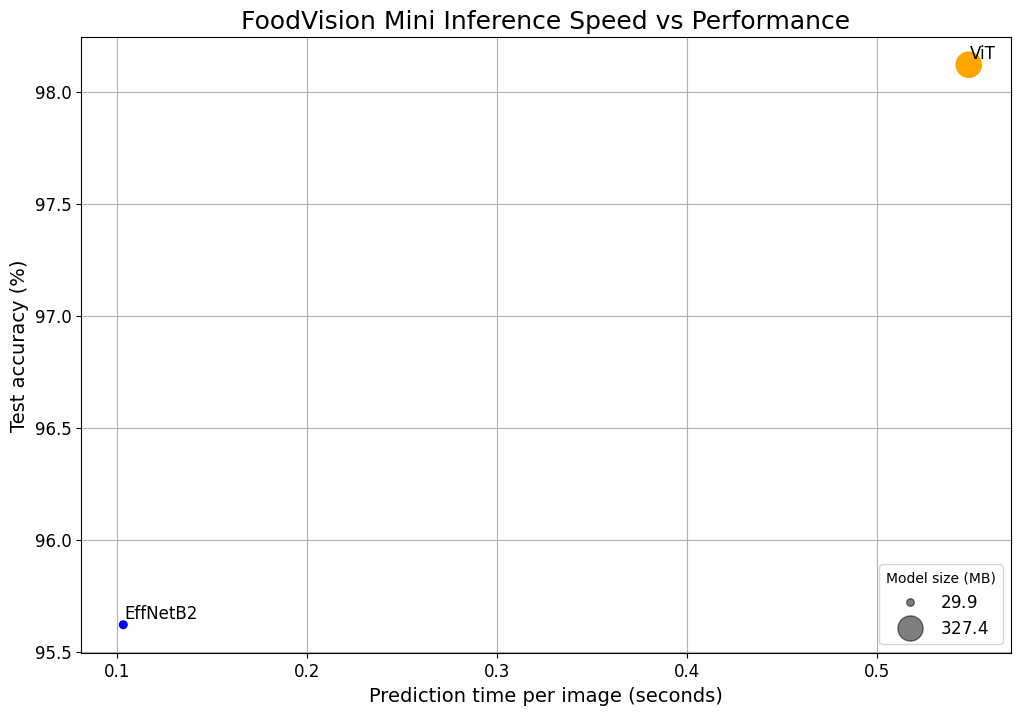

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

What is Gradio?

> https://www.gradio.app/



In [ ]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 5.31.0


### 7.1 Gradio overview

Gradio helps you create machine learning demos

Why create a demo?

So other people cna try our models and we can test them in real-world

Deployment is as important as training.


### 7.2 Create a function to map our inputs and outputs


In [ ]:
# Put model on the CPU

effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
Images of food -> ML model (EffNetB2) -> Outputs (food class label, prediction time)
```

In [ ]:
from typing import Tuple,Dict

def predict(img) -> Tuple[Dict,float]:
  # Start timer
  start_time = timer()

  # Transform the input image to use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # adding batch dim on 0th index

  # Put model into eval mode, make predictions
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and predictiong probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time-start_time,4)
  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test filenames
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Randomly select a test iamge
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg

{'pizza': 0.03456983342766762, 'steak': 0.0881769135594368, 'sushi': 0.8772532343864441}
0.0999


### 7.3 Creating a list of example images

https://www.gradio.app/docs

In [ ]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/40947.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

input: image -> transform -> predict with EffNetB2 - > output: pred, pred prob,time

In [ ]:
import gradio as gr

# Create title,description and article

title = "FoodVision Mini 🍕"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically sharable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c7a2d2aabb95279d5c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio demo into a deployable app


### 8.1 Hugging Face Spaces
https://huggingface.co/spaces

### 8.2 Deployed Gradio app structure

Let's start to put all of our files into a sigle directory:

```
Colab -> floder with all Gradio filer -> uplload app files to Hugging Face spaces -> deploy
```

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
    ```


### 8.3 Create a demos folder to store our app files

In [ ]:
import shutil
from pathlib import Path

# Create demo path
foodvision_mini_demo_path = Path("demo/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

We want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_example_path = foodvision_mini_demo_path / "examples"
foodvision_mini_example_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the example dir
for example in foodvision_mini_examples:
  destination = foodvision_mini_example_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)
  print(destination)
  print(example.name)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demo/foodvision_mini/examples/592799.jpg
demo/foodvision_mini/examples/592799.jpg
592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demo/foodvision_mini/examples/3622237.jpg
demo/foodvision_mini/examples/3622237.jpg
3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demo/foodvision_mini/examples/2582289.jpg
demo/foodvision_mini/examples/2582289.jpg
2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_example_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision mini model

In [ ]:
import shutil

# Create source path
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth"

# Create a destination path
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model to file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO Model move complete]")
# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth to demo/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth
[INFO Model move complete]


### 8.6 Turning EffNetB2 model into a python sript('model.py')

In [ ]:
%%writefile demo/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demo/foodvision_mini/model.py


### 8.7 Turning our FoodVision mini gradio app into a python scripy ('app.py')

The `app.py`will have 4 major parts:
1. Imports and classes names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our gradio interface + launch command

In [ ]:
%%writefile demo/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:

    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time



### 4. Gradio app ###

import gradio as gr

# Create title,description and article

title = "FoodVision Mini 🍕"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch()

Writing demo/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

The requirements file will tell HuggingFace space what software dependencies our app requires

* torch
* torchvision
* gradio

In [ ]:
%%writefile demo/foodvision_mini/requirements.txt

torch==2.6.0
torchvision==0.21.0
gr==1.27.0

Writing demo/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app on HuggingFace spaces

### 9.1 Downloading our FoodVision mini app files

In [ ]:
!ls demo/foodvision_mini/

09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [ ]:
# Change into foodvision_mini dir and then zip it
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizz_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 49%)
  adding: requirements.txt (deflated 9%)


In [ ]:
# Download
try:
    from google.colab import files
    files.download("demo/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running  Gradio demo locally

https://www.learnpytorch.io/09_pytorch_model_deployment/

### 9.3 Uploading our FoodVision Mini Gradio demo to hugging face spaces

steps - https://www.learnpytorch.io/09_pytorch_model_deployment/

We can also share our app by embedding it...

## 10. Creating FoodVision BIG

FoodVision Mini works well with 3 classes (pizza,steak,sushi)

Let's step tings up a notch and make FoodVision BIG, using all Food101 Classes

### 10.1 Creating a model for FoodVision Big + transforms

In [ ]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

summary(effnetb2_food101,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* Because we're working with a large number of classes, lets use TrvialAugment() as our data augmentation technique.

In [ ]:
# Creating training data transforms
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision big

In [ ]:
from torchvision import datasets

from pathlib import Path
data_dir = Path("data")

# Training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food_101_train_transforms, # apply data augmentation to training data
                              download=True)

# Test data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)



100%|██████████| 5.00G/5.00G [04:36<00:00, 18.1MB/s]


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experiments

We want our first few experiments to run as quick as possibe

To do so, let's make a subset of 20% of the data from the food101 dataset(testing and training)
    


In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on the origina dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Printout info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                  lengths=[length_1, length_2],
                                                                  generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
  return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


(15150, 5050)

In [ ]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders

In [ ]:
import os
import torch

NUM_WORKERS = 2

BATCH_SIZE = 32

# Create Food101 20% training dataloader

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# create 20% test dataloader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)


In [ ]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big

We'll use label smoothing.

**Lable smoothing** helps to prevent overfitting (it's a regularization technique)



In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=10,
                                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6449 | train_acc: 0.2777 | test_loss: 2.7838 | test_acc: 0.4858
Epoch: 2 | train_loss: 2.8628 | train_acc: 0.4395 | test_loss: 2.4746 | test_acc: 0.5332
Epoch: 3 | train_loss: 2.6560 | train_acc: 0.4855 | test_loss: 2.3637 | test_acc: 0.5574
Epoch: 4 | train_loss: 2.5459 | train_acc: 0.5093 | test_loss: 2.3044 | test_acc: 0.5733
Epoch: 5 | train_loss: 2.4970 | train_acc: 0.5215 | test_loss: 2.2807 | test_acc: 0.5798
Epoch: 6 | train_loss: 2.4333 | train_acc: 0.5393 | test_loss: 2.2674 | test_acc: 0.5818
Epoch: 7 | train_loss: 2.4105 | train_acc: 0.5454 | test_loss: 2.2366 | test_acc: 0.5907
Epoch: 8 | train_loss: 2.3880 | train_acc: 0.5507 | test_loss: 2.2405 | test_acc: 0.5926
Epoch: 9 | train_loss: 2.3672 | train_acc: 0.5590 | test_loss: 2.2211 | test_acc: 0.5991
Epoch: 10 | train_loss: 2.3458 | train_acc: 0.5598 | test_loss: 2.2255 | test_acc: 0.5959


### 10.6 Inspecting loss curves

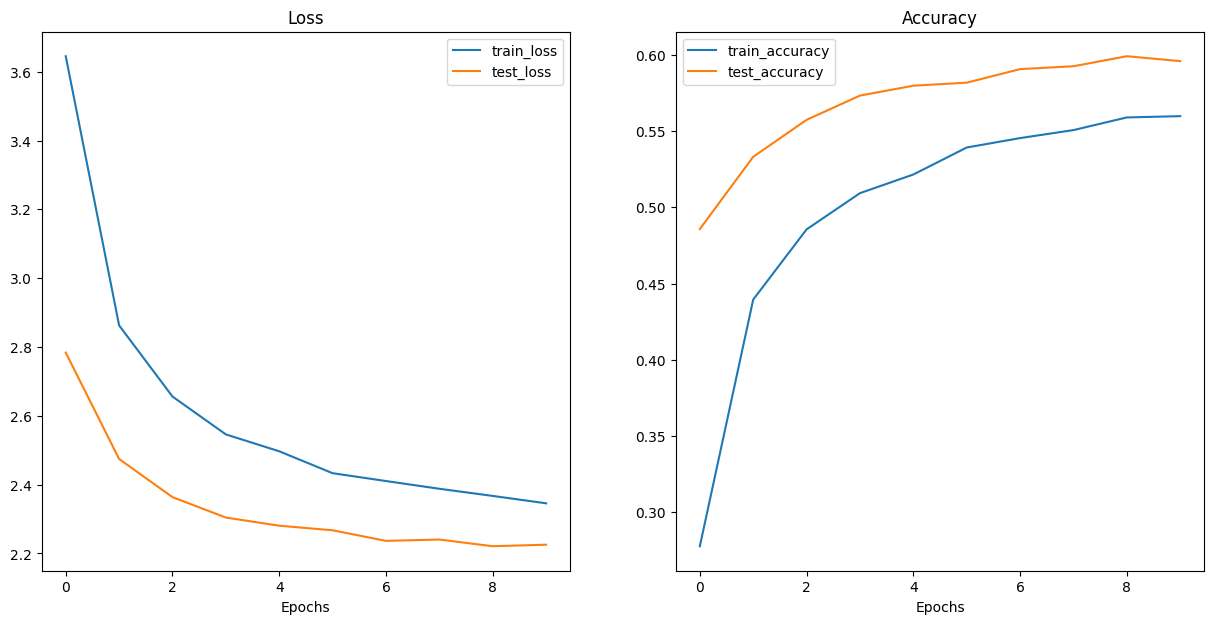

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load the model


In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 EffNetB2 model instance

loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning our FoodVision Big model into a deployable app

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
  ```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demo/foodvision_big")

from pathlib import Path

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory

In [ ]:
# Download and move example image
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demo/foodvision_big/examples/04-pizza-dad.jpg

--2025-07-06 17:24:02--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2025-07-06 17:24:02 (60.4 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demo/foodvision_big

### 11.2 Saving Food101 class names to file [`class_names.txt`]

Let's save all of the Food101 Class names to a .txt file so we can import and use them in our app

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demo/foodvision_big/class_names.txt')

In [ ]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demo/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our foodvision big model into python script (`model.py`)

In [ ]:
%%writefile demo/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demo/foodvision_big/model.py


### 11.4 Turning our FoodVision big gradio app into python script (`app.py`)

The app.pywill have 4 major parts:

1. Imports and classes names setup - for class names, we'll need to import from class_names.txt rather than a python list
2. Model and transforms preparation
3. Predict function (predict())
4. Gradio app - our gradio interface + launch command

In [ ]:
%%writefile demo/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food of 101 different classes from the Food101 Dataset"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time "),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demo/foodvision_big/app.py


### 11.5 Creating requirements.txt

In [ ]:
%%writefile demo/foodvision_big/requirements.txt

torch==2.6.0
torchvision==0.21.0
gr==1.27.0

Writing demo/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demo/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 48%)
  adding: requirements.txt (deflated 9%)


In [ ]:
# Download the zipped FoodVision Big app
try:
    from google.colab import files
    files.download("demo/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying FoodVision Big model to HuggingFace spaces
https://www.learnpytorch.io/09_pytorch_model_deployment/#117-deploying-our-foodvision-big-app-to-huggingface-spaces